# AutoGrad Implementation

This is the code of the course giving by Andrej Karpathy one of the greater AI guy

In [1]:
import math

In [2]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')
        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        return out

In [3]:
# I've just copy/paste this function
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


In [4]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [5]:
L

Value(data=-8.0)

In [6]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [7]:
d._op

'+'

In NN

In [8]:
from matplotlib import pyplot as plt
import numpy as np

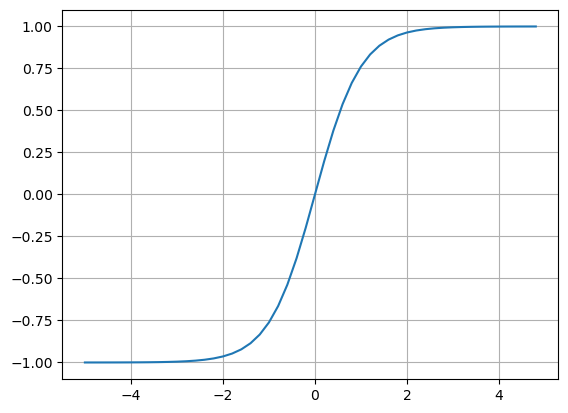

In [9]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2))); plt.grid()

In [10]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'

In [11]:
o.data

0.7071067811865476

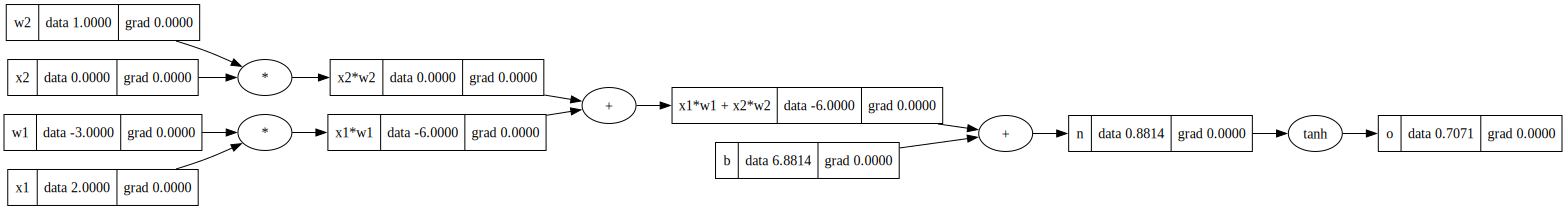

In [12]:
draw_dot(o)

We'll now implement backpropagation in the neuron

In [13]:
# start by o
# o = tanh(n)

In [14]:
o.grad = 1.0

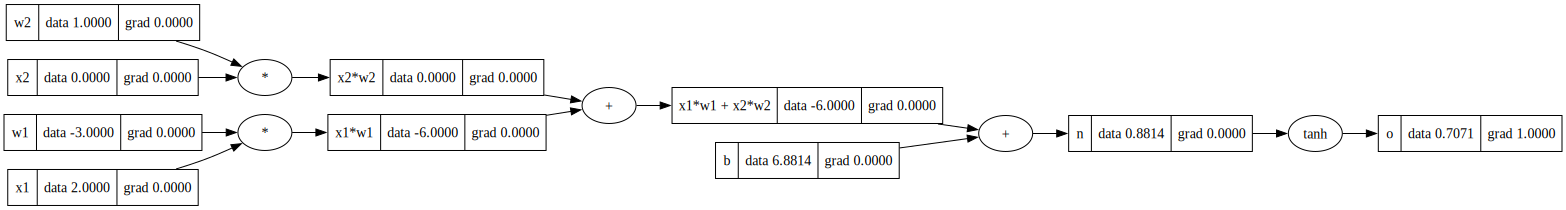

In [15]:
draw_dot(o)

do/dn = 1 - o**2

In [16]:
1 - o.data**2 #n.grad

0.4999999999999999

In [17]:
n.grad = 0.5

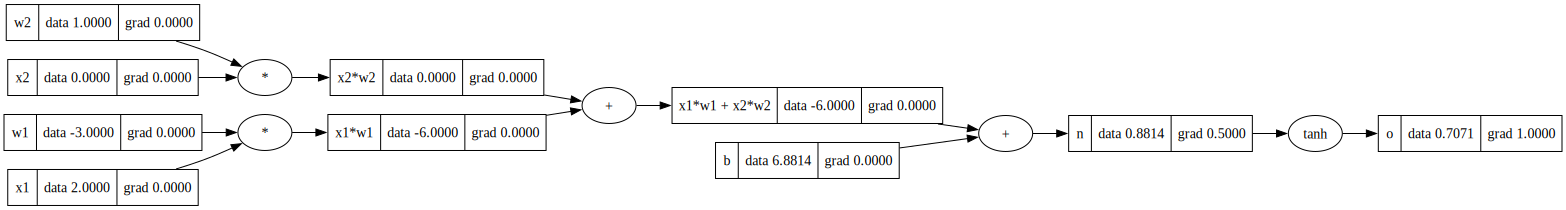

In [18]:
draw_dot(o)

logicaly we knew the b and the other sum will take n.grad

In [19]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

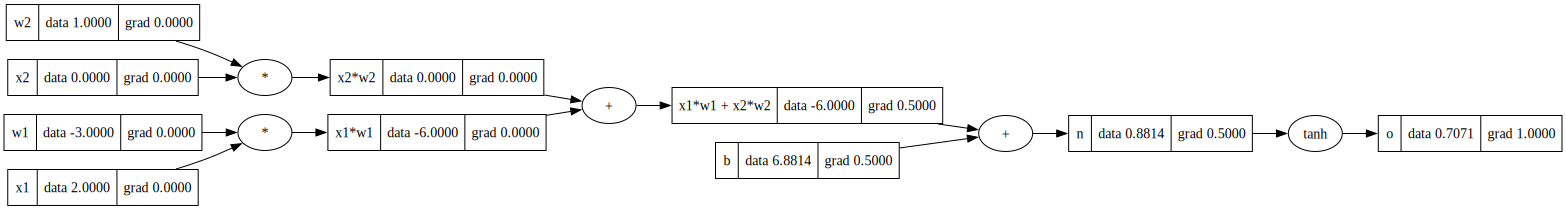

In [20]:
draw_dot(o)

It's the same for x2w2 and x1w1

In [21]:
x1w1.grad = 0.5
x2w2.grad = 0.5

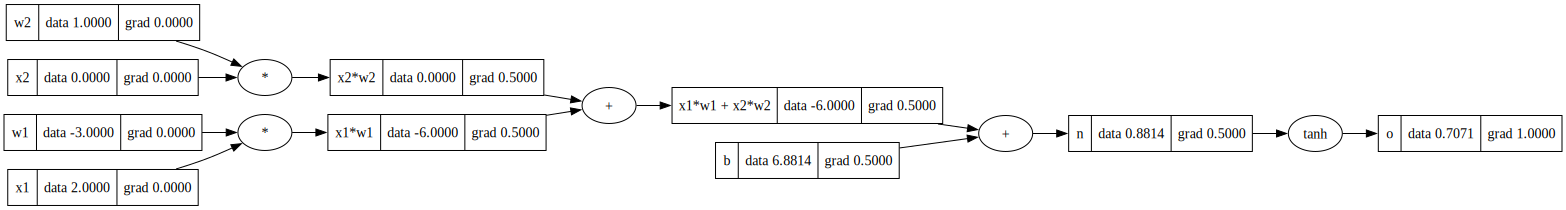

In [22]:
draw_dot(o)

In [23]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

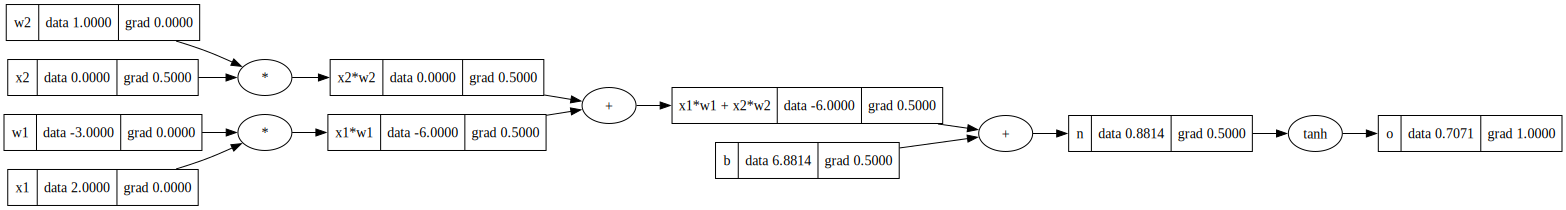

In [24]:
draw_dot(o)

In [25]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

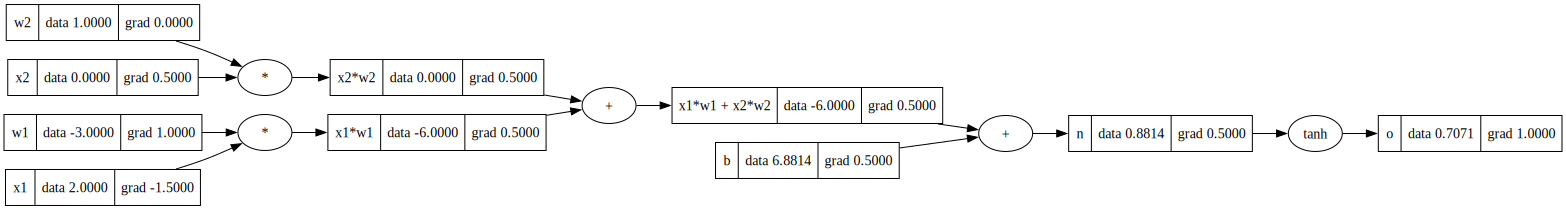

In [26]:
draw_dot(o)

We'll now automate the process of backpropag

In [27]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = self.data * out.grad
        out._backward = _backward

        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

In [28]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'

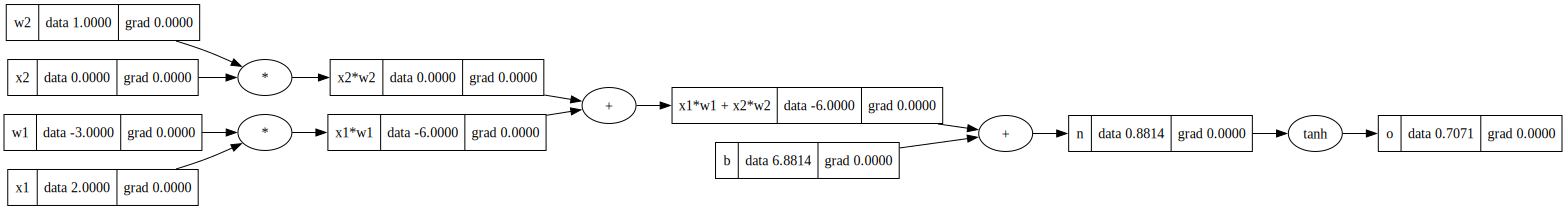

In [29]:
draw_dot(o)

We start by initialize o.grad

In [30]:
o.grad = 1.0

In [31]:
o._backward()

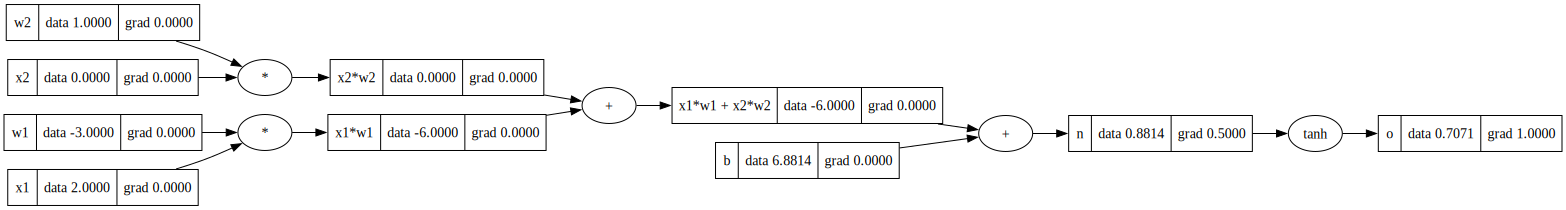

In [32]:
draw_dot(o)

In [33]:
n._backward()

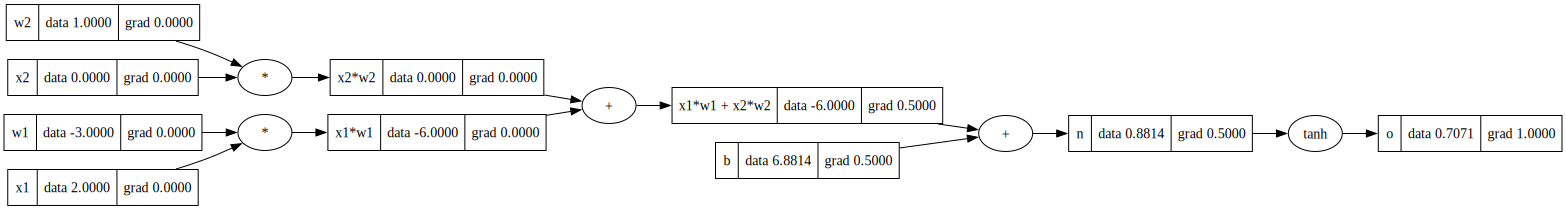

In [34]:
draw_dot(o)

In [35]:
x1w1x2w2._backward()

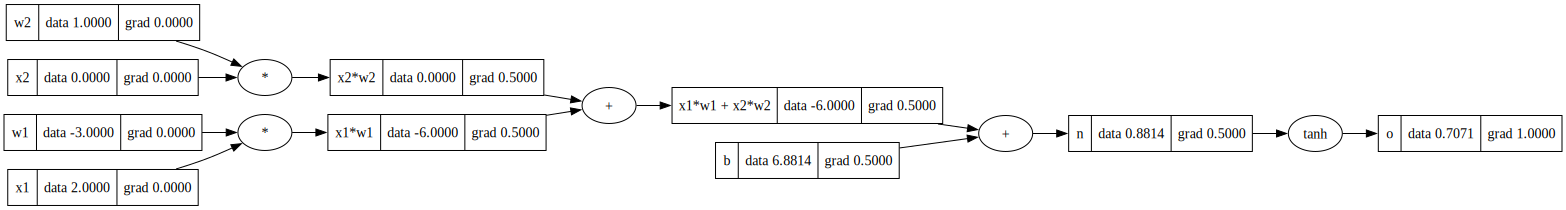

In [36]:
draw_dot(o)

In [37]:
b._backward()

Nothing will append, it's normal because b is a leave

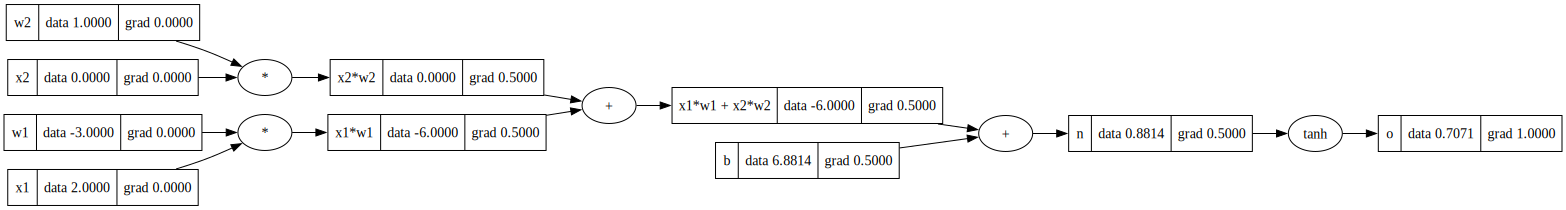

In [38]:
draw_dot(o)

In [39]:
x2w2._backward()
x1w1._backward()

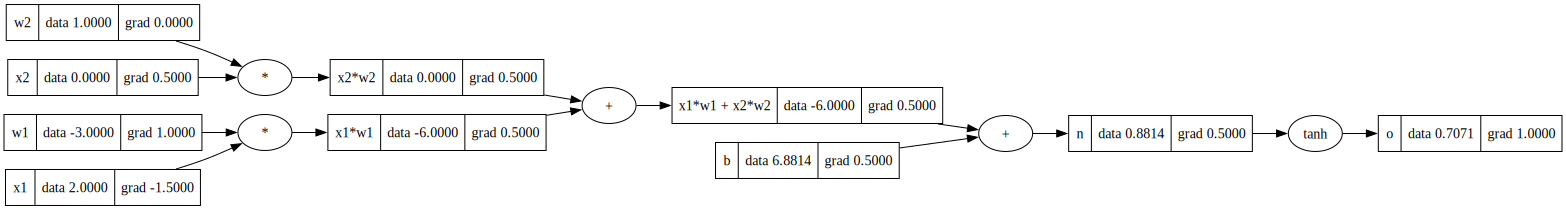

In [40]:
draw_dot(o)

Now, we'll automate the backpropagation process by implemeting topological sort in a backward function

In [41]:
o.grad = 1.0

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

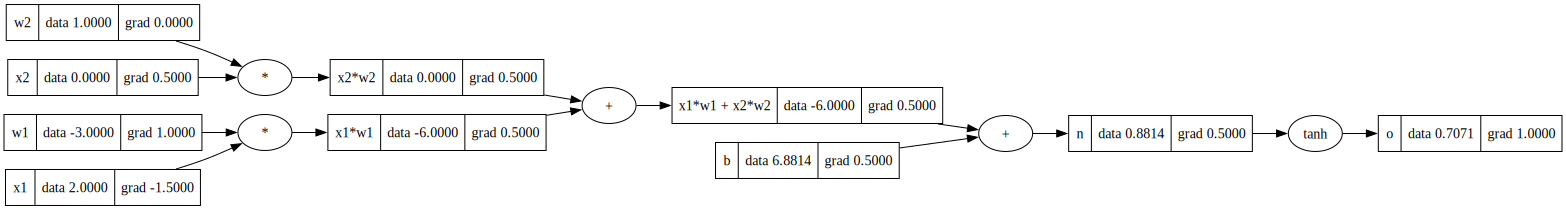

In [42]:
draw_dot(o)

It's perfect, we can add this functionality in our class

In [43]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = self.data * out.grad
        out._backward = _backward

        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [44]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'

In [45]:
o.backward()

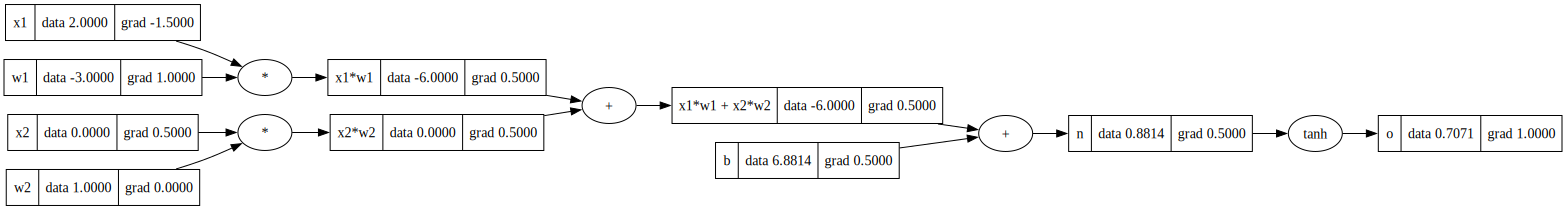

In [46]:
draw_dot(o)

yuuuy!!!!

But we have some issue !

In [47]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()

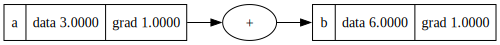

In [48]:
draw_dot(b)

It's not correct, because a is a "double" node, so a.grad have to be 2

In [49]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d + e ; f.label = 'f'

In [50]:
f.backward()

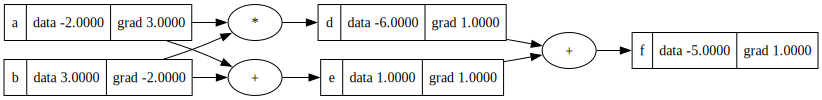

In [51]:
draw_dot(f)

Also wrong

The solution it's quitly simple, just before sure that every time we add in any operations new data without delete the previous one.

In [52]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad #there
            other.grad += 1.0 * out.grad #there
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data #there
            other.grad += self.data * out.grad #there
        out._backward = _backward

        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward += _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [53]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()

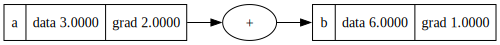

In [54]:
draw_dot(b)

In [55]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d + e ; f.label = 'f'

In [56]:
f.backward()

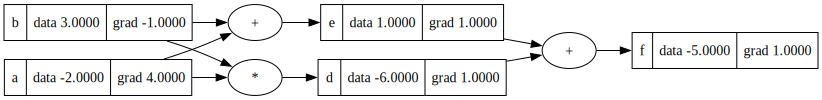

In [57]:
draw_dot(f)

Now we want the breaking up tanh

But for now we have another issue, we can't do any operations between Value object and real Number

In [58]:
1 + Value(2)

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [59]:
Value(2) + 1

AttributeError: 'int' object has no attribute 'data'

In [61]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad #there
            other.grad += 1.0 * out.grad #there
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data #there
            other.grad += self.data * out.grad #there
        out._backward = _backward

        return out 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward += _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [62]:
Value(2) + 1

Value(data=3)

But, one another

In [63]:
1 + Value(1)

TypeError: unsupported operand type(s) for +: 'int' and 'type'

It's because Python only know how to do a.__add__(2) but not to do 2.__add__(a)

In [70]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad #there
            other.grad += 1.0 * out.grad #there
        out._backward = _backward

        return out
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data #there
            other.grad += self.data * out.grad #there
        out._backward = _backward

        return out 
    
    ### we add rmul 
    def __rmul__(self,other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward += _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [72]:
1 + Value(2)

Value(data=3)

We can start with exp

In [73]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad #there
            other.grad += 1.0 * out.grad #there
        out._backward = _backward

        return out
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data #there
            other.grad += self.data * out.grad #there
        out._backward = _backward

        return out 
    
    ### we add rmul 
    def __rmul__(self,other):
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward += _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data 
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [74]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [75]:
a = Value(2.0)
b = Value(3.0)

a/b

TypeError: unsupported operand type(s) for /: 'Value' and 'Value'

We now solve the problem of division and exp(x) + 1

In [109]:
class Value:
    """
    stores a single scalar value and its gradient
    """

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out

    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data 
            other.grad += self.data * out.grad 
        out._backward = _backward

        return out 
    
    def __rmul__(self,other):
        return self * other
    
    #we add div
    def __truediv__(self,other):
        return self * other**-1
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), 'f**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data 
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                visited.add(v)
            topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [110]:
a = Value(2.0)
b = Value(3.0)

a/b

Value(data=0.6666666666666666)

In [111]:
a-b

Value(data=-1.0)

In [112]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

o = n.tanh();o.label='o'


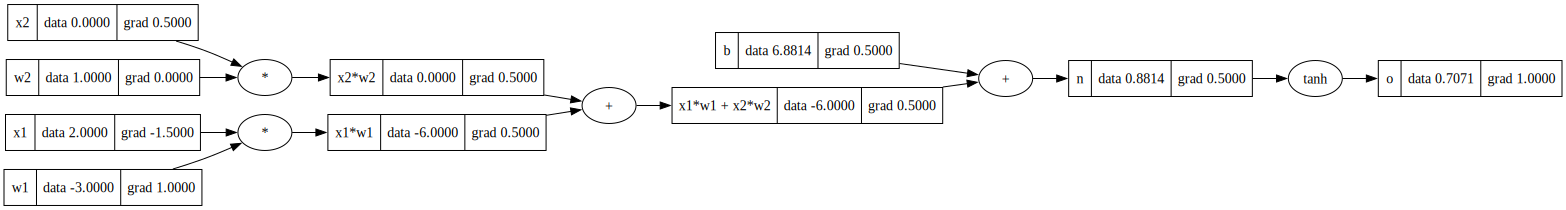

In [113]:
o.backward()
draw_dot(o)

In [114]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #combinaison of function without activation fonction (tanh for our cases)

# ----
e = (2*n).exp()
o = (e - 1)/(e + 1)
# ----

o.label='o'

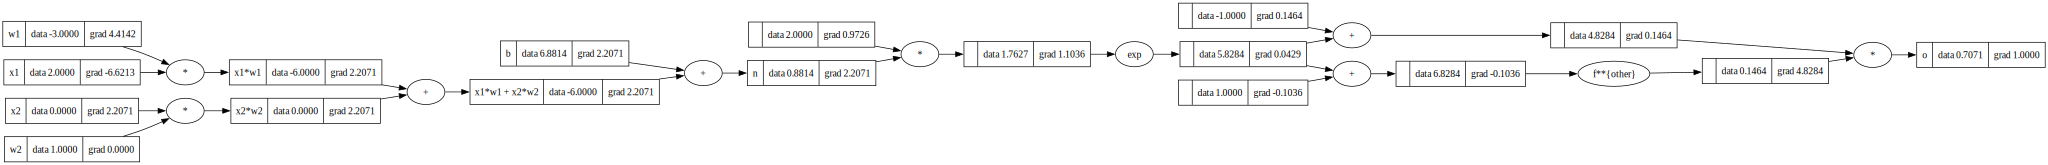

In [115]:
o.backward()
draw_dot(o)